In [199]:
import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from astropy import units as u
from astropy import coordinates as coord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.utils.data import get_pkg_data_filename

from urllib.request import urlretrieve


# Define Shell function for constant E. The general 
# modeling space is around 100-200 parsecs. E is constant in 
# this function, resulting in D being constant.


# R -> The distance from the centre
# t -> The time
# D -> Diffusion coefficient
# E is the energy, no energy is lost in this system

# R -> The distance from the centre
# t -> The time
# D -> Diffusion coefficient
# E is the energy, no energy is lost in this system

# n = [0.1, 0.5]
# Esn ~ e52
# alpha = []

@u.quantity_input(E = u.erg)
def dNdE(E, Emax = 5*u.PeV, Emin=1*u.GeV, n = 0.25, Esn = 1e52*u.erg, alpha = 1):
    n0 = (n*Esn*(-alpha+2))/(Emax**(2-alpha)-Emin**(2-alpha))*E**-alpha
    return n0


@u.quantity_input(t=u.yr, E=u.eV)
def Rshell(E, n0=10/u.cm**3, ESN=1e52*u.erg, Emax = 5*u.PeV, beta = 2.48):
    R = 0.31*(ESN/(1e51*u.erg))**(1/5)*(n0/(u.cm**-3))**(-1/5)*(Tesc(E, Emax, beta)/u.yr)**(2/5) *u.pc
    return R.to(u.pc)


@u.quantity_input(E=u.erg)
def Tesc(E, Emax = 5*u.PeV, beta = 2.48):
    ts = 1600*u.yr
    return (ts*(E/Emax)**(-1/beta)).to(u.yr)



@u.quantity_input(E=u.erg)
def diffusion(E, B = 50 * u.G*1e-6, x = 0.1, delta = 0.5):
    Dn = 3*10**27 * 0.1 
    dif = x * Dn * ((3*E/(u.GeV))/(10*B/(u.G*1e-6)))**delta
    return dif * u.cm**2 * u.s**-1

@u.quantity_input(E=u.erg, R=u.pc, t=u.yr)
def distribution(E, R, t, alpha = 2.7):
    Tpp = 6*(10**7) * u.yr
    Rdif = 2 * np.sqrt(diffusion(E) * (t - Tesc(E)))

    N = 1

    first1 = (np.pi**(1/2))*(Rdif**2) 
    first2 = 2*(np.pi**(1/2)*(Rshell(E))**2) 
    first3 = 4*Rshell(E)*(Rdif)
    
    firstT = first1 + first2 + first3

    dist = dNdE(E)*(firstT/(np.pi**(1/2)*(Rdif)**2))**(-1)*(1/(np.pi**(3/2)*(Rdif)**3))*np.exp(-(R-Rshell(E))**2/(Rdif)**2)

    return dist



E = float(input("At what energy ? ").strip())
if(E == 0):
    E = 5*u.TeV

T = float(input("At what time ? ").strip())
if(T == 0):
    T = 50*u.kyr

R = float(input("At what radius ? ").strip())
if(R == 0):
    R = 50*u.pc



5.0000010000002e+46 1 / PeV


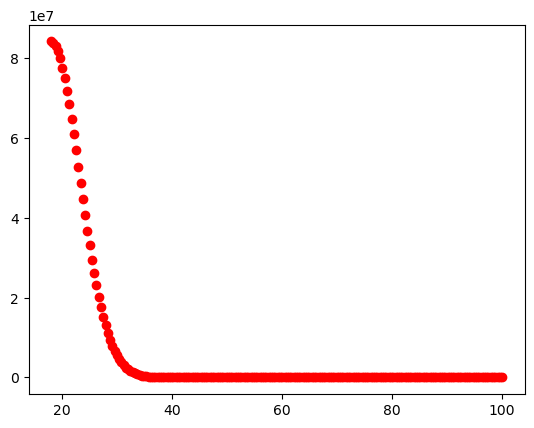

In [200]:
Rs = np.linspace(Rshell(E), 100*u.pc, 200)

for R in Rs:
    plt.plot(R, distribution([E]*u.TeV, R, T), 'ro')


C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


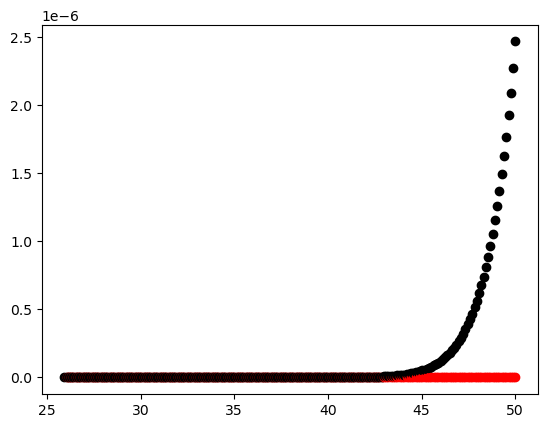

In [201]:
ts = np.linspace(Tesc(E).to(u.kyr).value, (50*u.kyr).to(u.kyr).value, 200)*u.kyr

for T in ts:
    plt.plot(T, distribution([E]*u.TeV, R, T), 'ro')
    plt.plot(T, distribution([E*10]*u.TeV, R, T), 'ko')


#plt.yscale("log")

C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


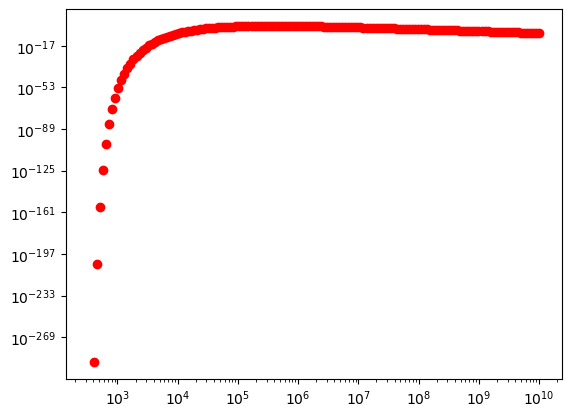

In [202]:
Es = np.logspace(0, 10, 200)*u.TeV

plt.plot(Es, distribution(Es, R, t), 'ro')
plt.yscale("log")
plt.xscale("log")